In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from netCDF4 import Dataset
from shapely.geometry import box, Polygon, LineString
import requests

from dotenv import load_dotenv
import os
import sys
from pathlib import Path

project_root = Path.cwd().parent  #to import from directory above
sys.path.append(str(project_root))

from LIBRARY_Spaceborne_CW import (
    Download_cWF_File,
    Download_cWF_File_List,
) 

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#Load and environment variables
load_dotenv(Path.cwd().parent / ".env")
username = os.getenv('GOLD_USER')
password = os.getenv('GOLD_PASS')
cWF_data_dir = os.getenv('CWF_DATA_DIR')

In [3]:
Download_cWF_File_List(username, password, cWF_data_dir)

CYGNSS complex waveform list file already present: /mnt/h/gnssr/cWF_data/List_CYGNSS_RawIF_Track.txt
TDS-1 complex waveform list file already present: /mnt/h/gnssr/cWF_data/List_TDS1_RawIF_Track.txt


In [4]:
filename=Path(cWF_data_dir) / 'List_TDS1_RawIF_Track.txt'
df = pd.read_csv(filename,delimiter=',',skiprows=1,index_col=False,
names=["RawIFCollection", "GNSS_PRN", "UTC", "Peak_NoiseFloor_Ration_d","Peak_NoiseFloor_Ration_r","Lat_0","Lon_0","Lat_1","Lon_1","incidence_angle","File_Name"])  
df.head()

,RawIFCollection,GNSS_PRN,UTC,Peak_NoiseFloor_Ration_d,Peak_NoiseFloor_Ration_r,Lat_0,Lon_0,Lat_1,Lon_1,incidence_angle,File_Name
0,2014-09-01H12RawCollection000001,G21,2014-09-01T10:36:00.7,45.5225,1.2526,8.7610,-16.5684,5.5233,-17.2680,32.2682,2014-09-01H12RawCollection000001_G21_cWF_Ocean.nc
1,2014-09-01H12RawCollection000001,G29,2014-09-01T10:36:00.7,11.3292,1.6337,16.7720,-14.6990,14.0831,-15.0808,66.9297,2014-09-01H12RawCollection000001_G29_cWF_Land.nc
2,2014-09-01H12RawCollection000001,G31,2014-09-01T10:36:00.7,88.3674,4.7367,10.8584,-19.6340,7.5785,-20.3392,26.1316,2014-09-01H12RawCollection000001_G31_cWF_Ocean.nc
3,2014-09-01H18RawCollection000000,G02,2014-09-01T20:10:00.7,52.4606,1.7898,44.8636,-150.3607,41.7195,-151.7425,38.8225,2014-09-01H18RawCollection000000_G02_cWF_Ocean.nc
4,2014-09-01H18RawCollection000000,G12,2014-09-01T20:10:00.7,59.9271,4.8352,45.9194,-153.4659,42.6895,-154.6733,21.8844,2014-09-01H18RawCollection000000_G12_cWF_Ocean.nc


In [5]:
#Create LineString geometries, take into account the antimeridian crossing
df["geometry"]=df.apply(lambda row: LineString([(row['Lon_0']+360, row['Lat_0']), (row['Lon_1'], row['Lat_1'])])
                        if (row['Lon_1']-row['Lon_0']>180) else 
                        LineString([(row['Lon_0'], row['Lat_0']), (row['Lon_1'], row['Lat_1'])]),axis=1)

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.explore()

Sea ice leads dataset:
Willmes, Sascha; Heineann, Günther; Reiser, Fabian (2023): ArcLeads: Daily sea-ice lead maps for the Arctic, 2002-2021, NOV-APR [dataset]. PANGAEA, https://doi.org/10.1594/PANGAEA.955561

In [6]:
#helper to get leads filenames for specific year
def get_leads_fname(leads_dir,year):
    return  leads_dir/ f'{year}{year-1999:02n}_ArcLeads.nc' 

In [7]:
leads_dir = Path(cWF_data_dir).parent / '~ancillary' / 'ArcAnt_LEADS' 


nc_path = get_leads_fname(leads_dir,2015)
ncfile = Dataset(str(nc_path), 'r')
print(ncfile)

time = np.copy(ncfile['time'])
lon = np.copy(ncfile['lon'])
lat = np.copy(ncfile['lat']) 
#leads = np.copy(ncfile['leadmap']) #this will crash the kernel - oom?
leads = np.array(ncfile['leadmap'][0])
ncfile.close()

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: ArcLeads daily binary
    subtitle: NOV-APR201516/
    author: Sascha Willmes, Trier University
    contact: willmes@uni-trier.de
    reference: https://www.mdpi.com/2072-4292/12/12/1957
    description: The ArcLeads dataset contains daily maps with categories: 0=clouds, 1=land, 2=sea ice, 3=artefacts, 4=leads, 5=open water.
    dimensions(sizes): nrows(5500), ncols(6000), time_dim(182)
    variables(dimensions): float32 lat(nrows, ncols), float32 lon(nrows, ncols), uint32 time(time_dim), uint8 leadmap(time_dim, nrows, ncols)
    groups: 


In [8]:
#Filter to keep only rows where UTC month is November through April (as covered by dataset)
gdf['UTC'] = pd.to_datetime(gdf['UTC'], errors='coerce')
winter_months = [11, 12, 1, 2, 3, 4]
gdf = gdf[gdf['UTC'].dt.month.isin(winter_months)].reset_index(drop=True)
print(f"Rows after filtering Nov-Apr: {len(gdf)}")


#Determine how many tracks overlap the dataset extent
corner_coords = [
    (float(lon[0, 0]), float(lat[0, 0])),
    (float(lon[0, -1]), float(lat[0, -1])),
    (float(lon[-1, -1]), float(lat[-1, -1])),
    (float(lon[-1, 0]), float(lat[-1, 0])),
]
arc_leads_outline = Polygon(corner_coords)

outline_3413 = gpd.GeoSeries([arc_leads_outline], crs="EPSG:4326").to_crs("EPSG:3413").iloc[0]
gdf = gdf.to_crs("EPSG:3413")

gdf=gdf[gdf.geometry.intersects(outline_3413)].reset_index(drop=True)

print(f"Rows after filtering spatially: {len(gdf)}")


Rows after filtering Nov-Apr: 327
Rows after filtering spatially: 43


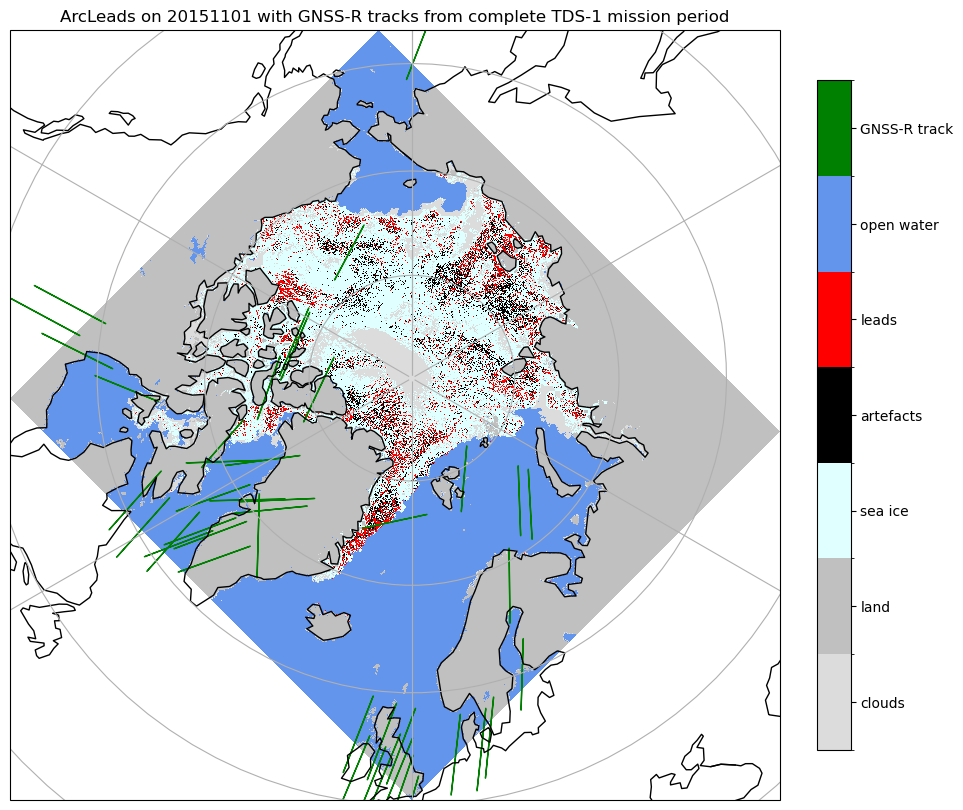

In [12]:
colors = ['gainsboro','silver','lightcyan','black','red','cornflowerblue','green']
#colors = ['w','w','w','w','red','w']
labels = ['clouds','land','sea ice','artefacts','leads','open water','GNSS-R track']
cmap = ListedColormap(colors)
norm = BoundaryNorm([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5], cmap.N)

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1,1,1, projection=ccrs.NorthPolarStereo())
transform = ccrs.PlateCarree() if (np.nanmin(lon) >= -180 and np.nanmax(lon) <= 360) else ccrs.NorthPolarStereo()

#plot the raster data (keeps axis defined by the raster dataset)
mesh = ax.pcolormesh(lon, lat, leads, transform=transform, cmap=cmap, norm=norm, shading='auto')

#overlay the track geometries
ax.add_geometries(
    gdf.geometry.buffer(500),
    crs=ccrs.epsg(3413),
    facecolor='none',
    edgecolor='green',
    linewidth=1,
    label='GNSS-R tracks'
)

ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.title(f'ArcLeads on {time[0]} with GNSS-R tracks from complete TDS-1 mission period')
cbar = plt.colorbar(mesh, ax=ax, fraction=0.036, pad=0.04, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)
gl = ax.gridlines()
plt.show()